# 0. Imports & define

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from geopy.geocoders import Nominatim
from kgcpy import lookupCZ

# define the path to the data folder
ResultsFolder = r'C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results'

# define the path to the site summary file
site_summary_path = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\25_05_01_Newsites_summary.xlsx"

# define the path to the file to add climate zone data
site_summary_path_to_add = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_01_Results\25_05_07_old_and_new_summary.xlsx"

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)
two_by_two_figsize = (12, 12)

# 1. Read the results

## 1.1. Read the results from folders

In [2]:
# Initialize an empty DataFrame
results_df = pd.DataFrame(
    columns=[
        'Site ID', 'Season', 'File',
        'Mean Frequency (Hz)', 'Mean Period (h)', 'Mismatch Loss (%)'
    ]
)

for folder in os.listdir(ResultsFolder):
    folder_path = os.path.join(ResultsFolder, folder)
    if not os.path.isdir(folder_path):
        continue

    site_id, season = folder.split('_')[:2]

    for file in os.listdir(folder_path):
        if not (file.endswith('.csv') or file.endswith('.xlsx')) or 'combined' not in file:
            continue

        # --- load data ---
        path = os.path.join(folder_path, file)
        df = pd.read_csv(path) if file.endswith('.csv') else pd.read_excel(path)

        # --- compute centroid frequency & period in hours ---
        timestamps = pd.to_datetime(df['Timestamp'])
        dt = (timestamps.iloc[1] - timestamps.iloc[0]).total_seconds()
        y  = df['Sum of I*V (W)'].values
        N  = len(y)

        y_centered = y - np.mean(y)
        y_fft      = np.fft.fft(y_centered)
        freqs      = np.fft.fftfreq(N, d=dt)

        # Only non-negative frequencies
        mask    = freqs >= 0
        freqs_p = freqs[mask]
        amp_p   = np.abs(y_fft[mask])
        power   = amp_p**2

        # centroid freq & period
        f_centroid   = np.sum(freqs_p * power) / np.sum(power)
        T_centroid_s = 1.0 / f_centroid if f_centroid > 0 else np.inf
        T_centroid_h = T_centroid_s / 3600.0 * 2

        # --- plot FFT amplitude spectrum ---
        # plt.figure(figsize=(10,5))
        # plt.plot(freqs_p, amp_p, lw=1)
        # plt.xlim(0, freqs_p.max())
        # plt.yscale('log')
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Amplitude')
        # plt.title(f'FFT of Sum of I*V — Site {site_id}, {season}')
        # plt.grid(True, which='both', ls='--', alpha=0.4)
        # plt.show()

        # print the results
        print(f"Site ID: {site_id}, Season: {season}, File: {file}")
        print(f"Mean Period (h): {T_centroid_h:.3f}")

        # calculate the Mismatch Loss (%) by taking the percentage diff between the sum of I*V and Pmax
        E_series = np.sum(df['Pmppt (W)'].values)
        E_mpp = np.sum(df['Sum of I*V (W)'].values)
        E_mismatch = E_mpp - E_series
        E_mismatch_loss = E_mismatch / E_mpp * 100.
        print(f"Mismatch Loss (%): {E_mismatch_loss:.3f}")

        # --- append a new row to the DataFrame ---
        results_df.loc[len(results_df)] = [
            site_id, season, file,
            f_centroid, T_centroid_h, E_mismatch_loss
        ]

# --- identify the row with the largest mean period (h) ---
if not results_df.empty:
    idx = results_df['Mean Period (h)'].idxmax()
    max_row = results_df.loc[idx]
    print(">>> Largest mean period:")
    print(max_row.to_frame().T)


if not results_df.empty:
    idx_mismatch = results_df['Mismatch Loss (%)'].idxmax()
    max_mismatch_row = results_df.loc[idx_mismatch]
    print(">>> Largest mismatch loss:")
    print(max_mismatch_row.to_frame().T)

# export the results to an Excel file in the Results folder
results_df.to_excel(os.path.join(ResultsFolder, 'combined_results.xlsx'), index=False)

Site ID: 3455043, Season: autumn, File: combined_data_autumn_3455043.xlsx
Mean Period (h): 6.793
Mismatch Loss (%): 14.935
Site ID: 3455043, Season: spring, File: combined_data_spring_3455043.xlsx
Mean Period (h): 11.808
Mismatch Loss (%): 16.680
Site ID: 3455043, Season: summer, File: combined_data_summer_3455043.xlsx
Mean Period (h): 9.105
Mismatch Loss (%): 13.015
Site ID: 3455043, Season: winter, File: combined_data_winter_3455043.xlsx
Mean Period (h): 14.541
Mismatch Loss (%): 21.204
Site ID: 4002138, Season: autumn, File: combined_data_autumn_4002138.xlsx
Mean Period (h): 11.527
Mismatch Loss (%): 7.930
Site ID: 4002138, Season: spring, File: combined_data_spring_4002138.xlsx
Mean Period (h): 4.481
Mismatch Loss (%): 100.000
Site ID: 4002138, Season: summer, File: combined_data_summer_4002138.xlsx
Mean Period (h): 14.610
Mismatch Loss (%): 6.483
Site ID: 4002138, Season: winter, File: combined_data_winter_4002138.xlsx
Mean Period (h): 8.272
Mismatch Loss (%): 13.061
Site ID: 4034

## 1.2. Add the summary information to the combined df

In [3]:
# 1.2. Add the summary information to the combined df

# Read the site summary Excel file
site_summary_df = pd.read_excel(site_summary_path, sheet_name='Sheet1')

# Ensure 'Site ID' columns are the same type (string is safest)
results_df['Site ID'] = results_df['Site ID'].astype(str)
site_summary_df['Site ID'] = site_summary_df['Site ID'].astype(str)

# Merge the results DataFrame with the site summary DataFrame on 'Site ID'
combined_df = pd.merge(results_df, site_summary_df, on='Site ID', how='left')

# remove the line with mismatch loss >= 100%
print(combined_df)
combined_df = combined_df[combined_df['Mismatch Loss (%)'] < 100]

# Export the merged DataFrame to an Excel file in the Results folder
combined_df.to_excel(os.path.join(ResultsFolder, 'combined_results_with_summary.xlsx'), index=False)

    Site ID  Season                               File  Mean Frequency (Hz)  \
0   3455043  autumn  combined_data_autumn_3455043.xlsx             0.000082   
1   3455043  spring  combined_data_spring_3455043.xlsx             0.000047   
2   3455043  summer  combined_data_summer_3455043.xlsx             0.000061   
3   3455043  winter  combined_data_winter_3455043.xlsx             0.000038   
4   4002138  autumn  combined_data_autumn_4002138.xlsx             0.000048   
..      ...     ...                                ...                  ...   
76  4186157  autumn  combined_data_autumn_4186157.xlsx             0.000061   
77  4186157  spring  combined_data_spring_4186157.xlsx             0.000042   
78  4186157  summer  combined_data_summer_4186157.xlsx             0.000087   
79  4186157  winter  combined_data_winter_4186157.xlsx             0.000048   
80  4197100  winter  combined_data_winter_4197100.xlsx             0.000096   

    Mean Period (h)  Mismatch Loss (%)  No        C

## 1.3. Add the results into summary

In [4]:
# read the combined_df, and also read the new sites summary data
combined_df = pd.read_excel(os.path.join(ResultsFolder, 'combined_results_with_summary.xlsx'))
site_summary_df = pd.read_excel(site_summary_path, sheet_name='Sheet1')

# loop through each row of the site summary df
for i, row in site_summary_df.iterrows():
    # get the site ID and season
    site_id = row['Site ID']
    
    # print(f"Processing site {site_id}")

    # look up the site ID in the combined df
    site_rows = combined_df[combined_df['Site ID'] == site_id]

    # loop through the rows of the site_rows df
    for j, site_row in site_rows.iterrows():
        # read the mismatch loss
        mismatch_loss = site_row['Mismatch Loss (%)']
        # read the season
        season = site_row['Season']
        # overwrite the the row in the site_summary df with the new column
        site_summary_df.loc[i, season + ' Mismatch Loss (%)'] = mismatch_loss

# add an extra colunn of the site summary df with the mean of the four seasons
site_summary_df['Mean Mismatch Loss (%)'] = site_summary_df[['summer Mismatch Loss (%)', 'autumn Mismatch Loss (%)', 'winter Mismatch Loss (%)', 'spring Mismatch Loss (%)']].mean(axis=1)

# export the results
site_summary_df.to_excel(os.path.join(ResultsFolder, 'site_summary_with_mismatch_loss.xlsx'), index=False)

## 1.4. Add climate zone

In [5]:
# read the site summary file to add climate zone data
site_summary_df = pd.read_excel(site_summary_path_to_add, sheet_name='Sheet1')

# Add climate zone column if not present
if 'Climate Zone' not in site_summary_df.columns:
    site_summary_df['Climate Zone'] = None

# Mapping from Köppen–Geiger code to full name
kg_full_names = {
    "Af": "Tropical rainforest",
    "Am": "Tropical monsoon",
    "Aw": "Tropical savanna",
    "As": "Tropical dry savanna",
    "BWk": "Cold desert",
    "BWh": "Hot desert",
    "BSk": "Cold semi-arid",
    "BSh": "Hot semi-arid",
    "Csa": "Hot-summer Mediterranean",
    "Csb": "Warm-summer Mediterranean",
    "Csc": "Cold-summer Mediterranean",
    "Cwa": "Monsoon-influenced humid subtropical",
    "Cwb": "Subtropical highland oceanic",
    "Cwc": "Cold subtropical highland",
    "Cfa": "Humid subtropical",
    "Cfb": "Oceanic",
    "Cfc": "Subpolar oceanic",
    "Dsa": "Hot-summer humid continental",
    "Dsb": "Warm-summer humid continental",
    "Dsc": "Subarctic",
    "Dsd": "Extremely cold subarctic",
    "Dwa": "Monsoon-influenced hot-summer humid continental",
    "Dwb": "Monsoon-influenced warm-summer humid continental",
    "Dwc": "Monsoon-influenced subarctic",
    "Dwd": "Monsoon-influenced extremely cold subarctic",
    "Dfa": "Hot-summer humid continental",
    "Dfb": "Warm-summer humid continental",
    "Dfc": "Subarctic",
    "Dfd": "Extremely cold subarctic",
    "ET": "Tundra",
    "EF": "Ice cap"
}

geolocator = Nominatim(user_agent="climate-zone-app")

for i, row in site_summary_df.iterrows():
    address = row['Address']
    try:
        loc = geolocator.geocode(address, timeout=10)
        if loc is not None:
            kg_code = lookupCZ(loc.latitude, loc.longitude)
            kg_full = kg_full_names.get(kg_code, kg_code)
            site_summary_df.at[i, 'Climate Zone'] = kg_full
        else:
            site_summary_df.at[i, 'Climate Zone'] = 'Not found'
    except Exception as e:
        print(f"Error for address '{address}': {e}")
        site_summary_df.at[i, 'Climate Zone'] = 'Error'

# Save with climate zone
site_summary_df.to_excel(os.path.join(ResultsFolder, 'new_and_old_with_climate_zone.xlsx'), index=False)

# 2. Visualise the mismatch losses

## 2.1. Using the data where season are same row

### 2.1.1. Pre processing

In [6]:
# read the file with climate zone data
site_summary_df = site_summary_df.copy()

# define hte values vars
value_vars = ['summer Mismatch Loss (%)', 'autumn Mismatch Loss (%)', 
              'winter Mismatch Loss (%)', 'spring Mismatch Loss (%)']

# define the id vars
id_vars = [col for col in site_summary_df.columns 
           if col not in value_vars and col != 'Mean Mismatch Loss']

# restructure the data to have one row per site and season
site_summary_df = site_summary_df.melt(id_vars=id_vars, 
                                         value_vars=['summer Mismatch Loss (%)', 'autumn Mismatch Loss (%)', 
                                                     'winter Mismatch Loss (%)', 'spring Mismatch Loss (%)'],
                                         var_name='Season', value_name='Mismatch Loss')


# export the results to an Excel file in the Results folder
site_summary_df.to_excel(os.path.join(ResultsFolder, 'new_and_old_with_climate_zone_melted.xlsx'), index=False)

### 2.1.2. Group by climate zone

#### 2.1.2.1. Seperate by shaded and not shaded

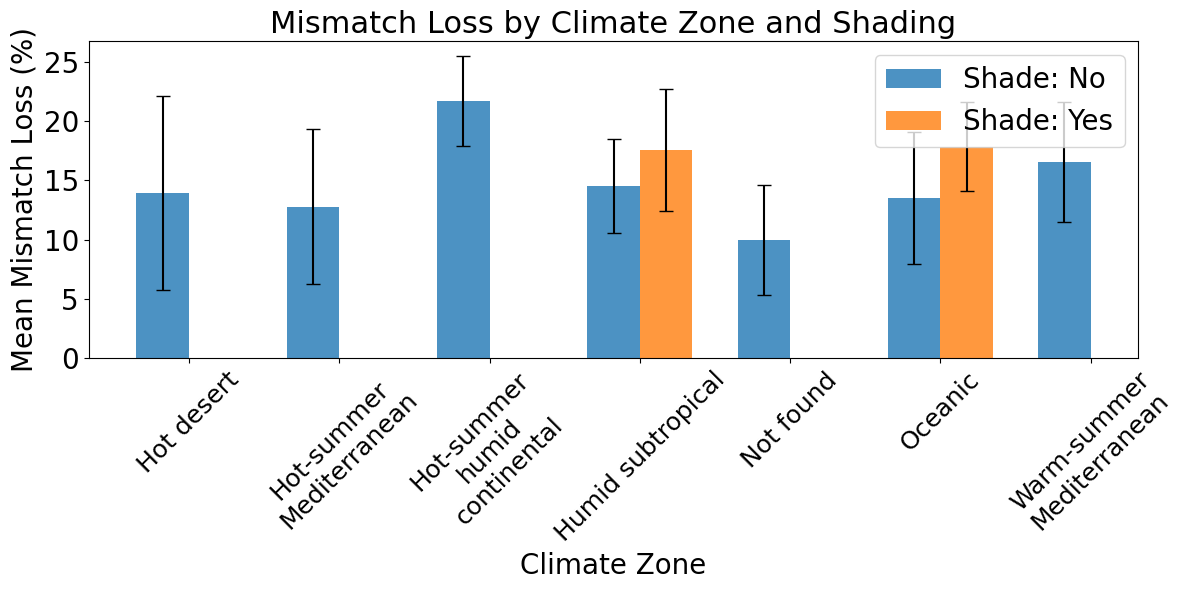

In [7]:
# --- 2.1.2.1. Climate Zone vs. Mismatch Loss, separated by Shade ---

# compute mean & std of mismatch loss by Climate Zone and Shade
stats = site_summary_df.groupby(['Climate Zone', 'Shade'])['Mismatch Loss'].agg(['mean', 'std'])
pivot_mean = stats['mean'].unstack('Shade')
pivot_std  = stats['std'].unstack('Shade')

# plot grouped bar chart
plt.figure(figsize=long_hoz_figsize)
bar_width = 0.35
x = np.arange(len(pivot_mean.index))

for i, shade in enumerate(pivot_mean.columns):
    plt.bar(
        x + i * bar_width,
        pivot_mean[shade],
        yerr=pivot_std[shade],
        width=bar_width,
        label=f'Shade: {shade}',
        capsize=5,
        alpha=0.8
    )

plt.xlabel('Climate Zone', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Climate Zone and Shading', fontsize=title_size)

# wrap long climate zone labels
wrapped = [
    cz if len(str(cz)) < 18 else '\n'.join(str(cz).split(' '))
    for cz in pivot_mean.index
]
plt.xticks(
    ticks=x + bar_width / 2,
    labels=wrapped,
    rotation=45,
    ha='center',
    fontsize=axis_num_size - 2
)
plt.yticks(fontsize=axis_num_size)
plt.legend(fontsize=axis_num_size, loc='upper right')
plt.tight_layout()
plt.show()

#### 2.1.2.2. Seperate by oeriantation

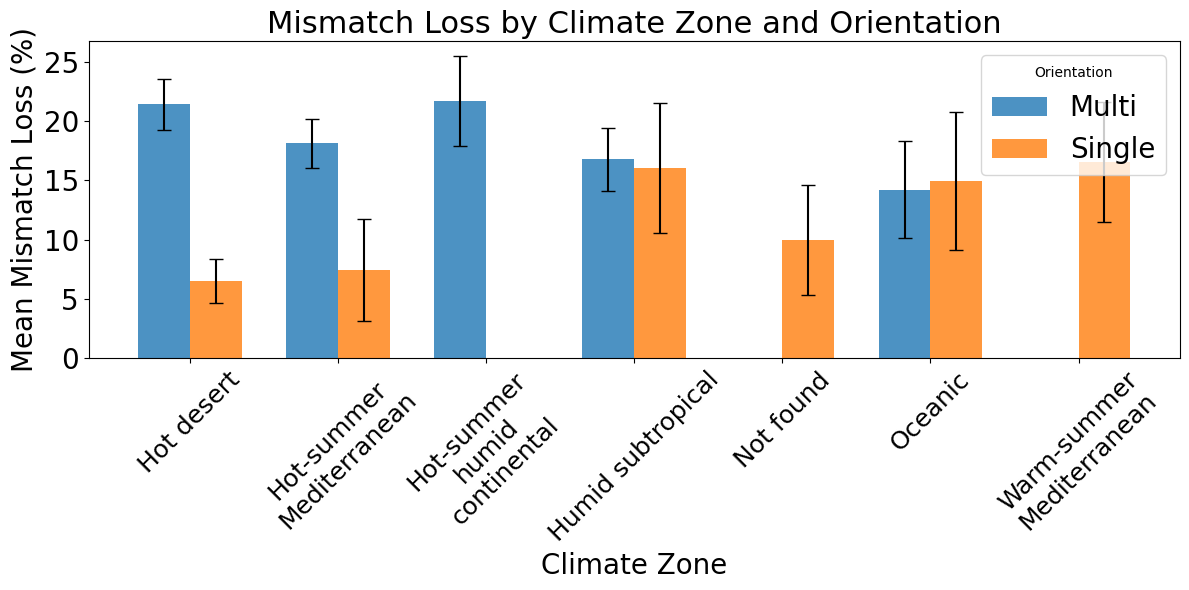

In [8]:
# --- 2.1.2.2. Climate Zone vs. Mismatch Loss, separated by Orientation ---

# compute mean & std by Climate Zone and Orientation
stats_orient = site_summary_df.groupby(
    ['Climate Zone','Orientation']
)['Mismatch Loss'].agg(['mean','std'])
pivot_orient_mean = stats_orient['mean'].unstack('Orientation')
pivot_orient_std  = stats_orient['std'].unstack('Orientation')

# plot grouped bar chart
plt.figure(figsize=long_hoz_figsize)
bar_width = 0.35
n_orients = len(pivot_orient_mean.columns)
x = np.arange(len(pivot_orient_mean.index))

for i, orient in enumerate(pivot_orient_mean.columns):
    plt.bar(
        x + i*bar_width,
        pivot_orient_mean[orient],
        yerr=pivot_orient_std[orient],
        width=bar_width,
        label=orient,
        capsize=5,
        alpha=0.8
    )

plt.xlabel('Climate Zone', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Climate Zone and Orientation', fontsize=title_size)

# wrap long climate zone labels
wrapped = [
    cz if len(str(cz)) < 18 else '\n'.join(str(cz).split(' '))
    for cz in pivot_orient_mean.index
]
plt.xticks(
    ticks=x + (n_orients-1)/2*bar_width,
    labels=wrapped,
    rotation=45,
    ha='center',
    fontsize=axis_num_size-2
)
plt.yticks(fontsize=axis_num_size)
plt.legend(title='Orientation', fontsize=axis_num_size, loc='upper right')
plt.tight_layout()
plt.show()

#### 2.1.2.3. Together

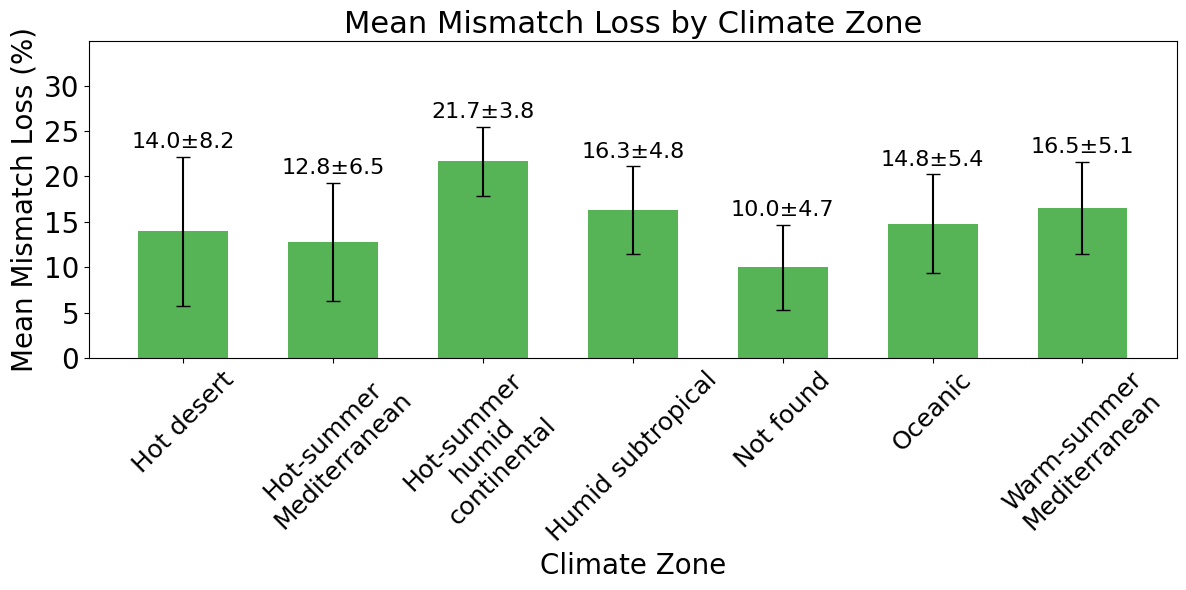

In [9]:
# --- 2.1.2.3. Mean Mismatch Loss by Climate Zone (Combined) ---

# compute mean & std by Climate Zone
stats_zone = site_summary_df.groupby('Climate Zone')['Mismatch Loss'].agg(['mean','std']).reset_index()

# prepare x‐positions
x = np.arange(len(stats_zone))
bar_width = 0.6

plt.figure(figsize=long_hoz_figsize)
bars = plt.bar(
    x,
    stats_zone['mean'],
    yerr=stats_zone['std'],
    width=bar_width,
    alpha=0.8,
    capsize=5,
    color='C2'
)

plt.xlabel('Climate Zone', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mean Mismatch Loss by Climate Zone', fontsize=title_size)

# wrap long labels
wrapped = [
    cz if len(str(cz)) < 18 else '\n'.join(str(cz).split(' '))
    for cz in stats_zone['Climate Zone']
]
plt.xticks(
    ticks=x,
    labels=wrapped,
    rotation=45,
    ha='center',
    fontsize=axis_num_size - 2
)
plt.yticks(fontsize=axis_num_size)
plt.ylim(0, stats_zone['mean'].max() + stats_zone['std'].max() + 5)
plt.tight_layout()

# annotate bars
for bar, m, s in zip(bars, stats_zone['mean'], stats_zone['std']):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        m + s + 0.5,
        f"{m:.1f}±{s:.1f}",
        ha='center', va='bottom',
        fontsize=axis_num_size - 4
    )

plt.show()

### 2.1.3. Season

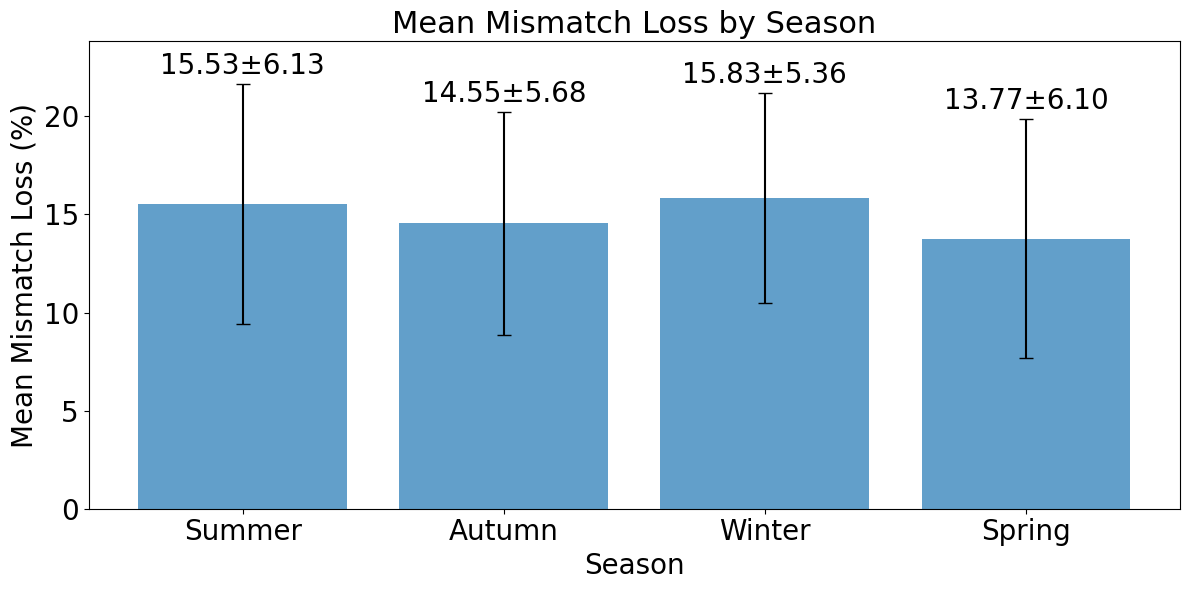

In [10]:
df = pd.read_excel(os.path.join(ResultsFolder, 'new_and_old_with_climate_zone.xlsx'))

# 2. Specify the seasonal columns exactly as they appear
season_cols = [
    'summer Mismatch Loss (%)',
    'autumn Mismatch Loss (%)',
    'winter Mismatch Loss (%)',
    'spring Mismatch Loss (%)'
]

# 3. Compute mean & std for each season column
means = df[season_cols].mean()
stds  = df[season_cols].std()

# 4. Create readable season labels
seasons = [col.split()[0].capitalize() for col in season_cols]

# 5. Plot bar chart with error bars
plt.figure(figsize=long_hoz_figsize)
bars = plt.bar(
    seasons,
    means,
    yerr=stds,
    capsize=5,
    alpha=0.7
)

plt.xlabel('Season', fontsize=axis_label_size)
plt.ylabel('Mean Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mean Mismatch Loss by Season', fontsize=title_size)

plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.ylim(0, (means + stds).max() * 1.1)

# 6. Annotate each bar with mean ± std
for bar, m, s in zip(bars, means, stds):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        m + s + 0.2,
        f"{m:.2f}±{s:.2f}",
        ha='center',
        va='bottom',
        fontsize=text_size
    )

plt.tight_layout()
plt.show()


## 2.2. Using the data where season are different row

### 2.2.1. Overall hist

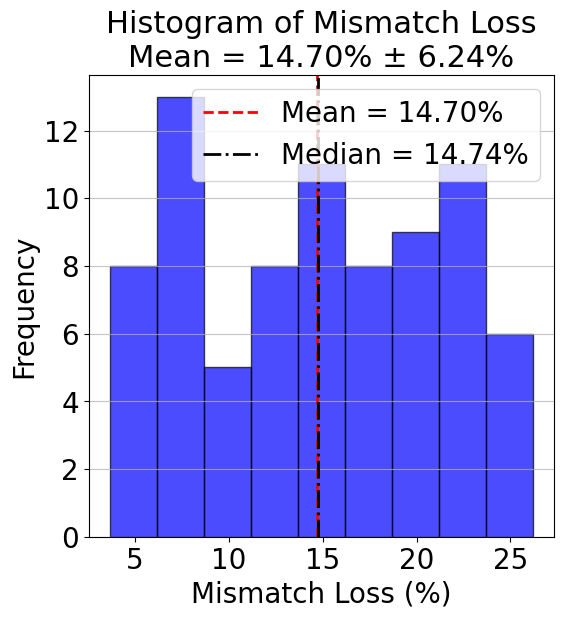

In [11]:
# plot a histogram of the mismatch loss
plt.figure(figsize=figure_size)
plt.hist(combined_df['Mismatch Loss (%)'], bins=9, color='blue', alpha=0.7, edgecolor='black')

# Calculate mean, median, and std
mean_val = combined_df['Mismatch Loss (%)'].mean()
median_val = combined_df['Mismatch Loss (%)'].median()
std_val = combined_df['Mismatch Loss (%)'].std()

# Plot vertical lines for mean and median
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}%")
plt.axvline(median_val, color='black', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f}%")

plt.xlabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.ylabel('Frequency', fontsize=axis_label_size)
plt.title(f'Histogram of Mismatch Loss\nMean = {mean_val:.2f}% ± {std_val:.2f}%', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.legend(fontsize=axis_num_size)
plt.show()

### 2.2.2. Plot against mean frequency

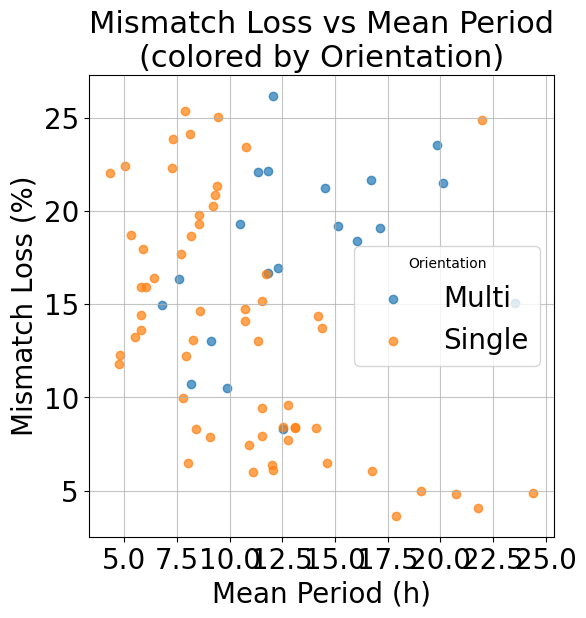

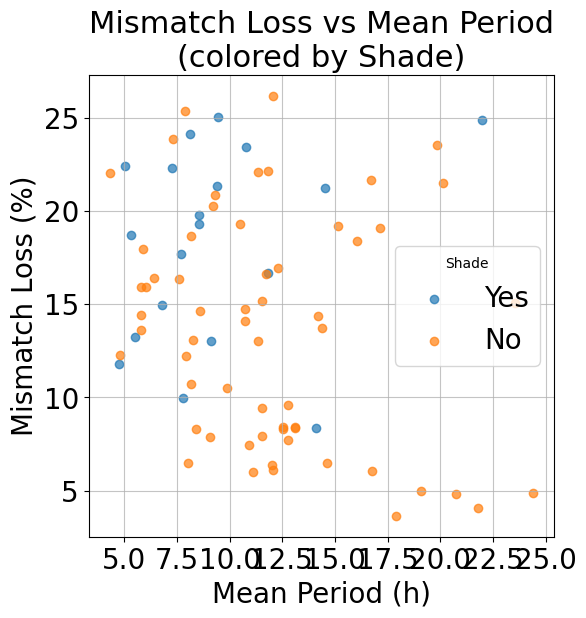

Multi: Slope = 0.3911
Single: Slope = -0.6839


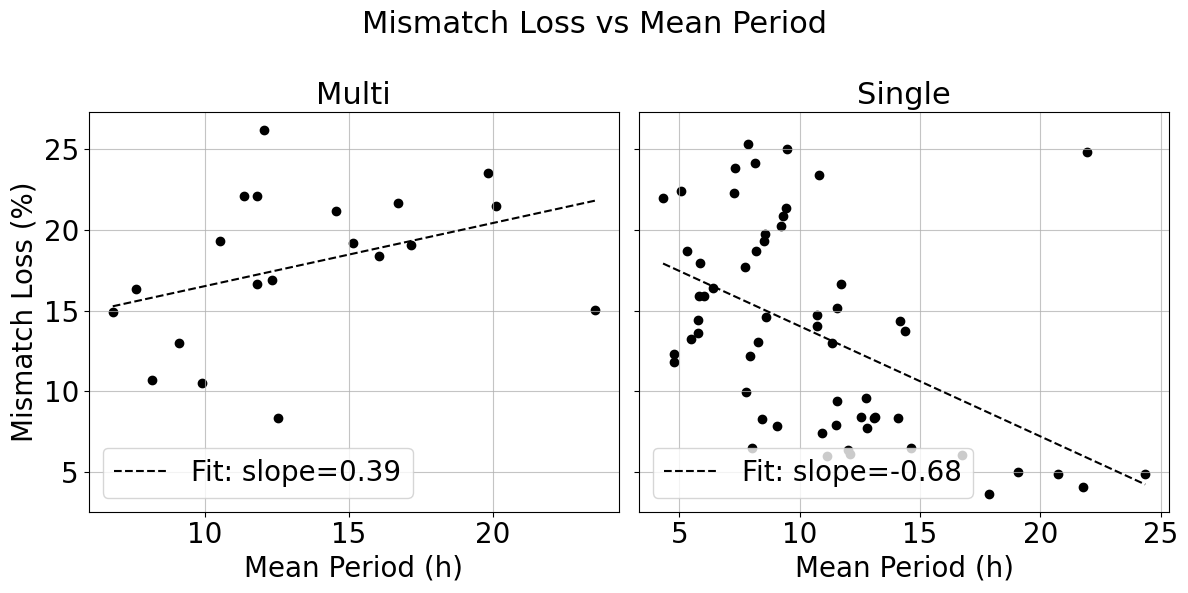

Shaded: Slope = 0.3013
Unshaded: Slope = -0.3234


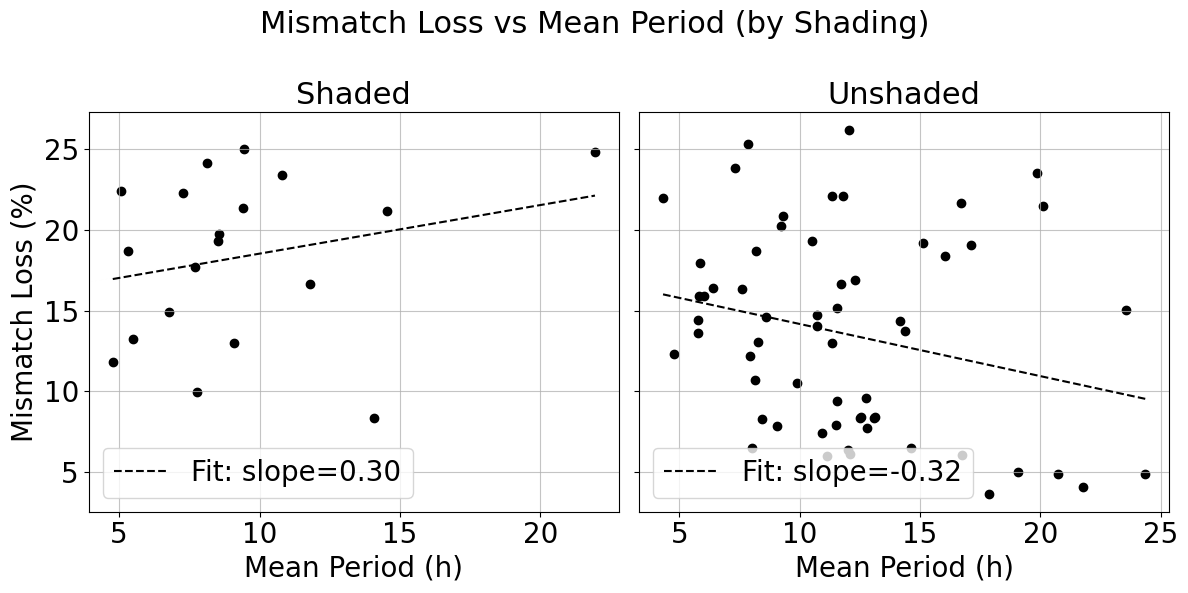

In [12]:
# plot the mismatch loss vs mean period, colored by orientation
plt.figure(figsize=figure_size)
orientations = combined_df['Orientation'].unique()
colors = plt.cm.tab10.colors  # up to 10 unique colors

for idx, orientation in enumerate(orientations):
    subset = combined_df[combined_df['Orientation'] == orientation]
    plt.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color=colors[idx % len(colors)],
        alpha=0.7,
        label=str(orientation)
    )

plt.xlabel('Mean Period (h)', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss vs Mean Period\n(colored by Orientation)', fontsize=title_size)
plt.grid(alpha=0.75)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.legend(title='Orientation', fontsize=axis_num_size)
plt.show()



# plot the mismatch loss vs mean period, colored by Shade
plt.figure(figsize=figure_size)
shades = combined_df['Shade'].unique()
colors = plt.cm.tab10.colors  # up to 10 unique colors

for idx, shade in enumerate(shades):
    subset = combined_df[combined_df['Shade'] == shade]
    plt.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color=colors[idx % len(colors)],
        alpha=0.7,
        label=str(shade)
    )

plt.xlabel('Mean Period (h)', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss vs Mean Period\n(colored by Shade)', fontsize=title_size)
plt.grid(alpha=0.75)
plt.xticks(fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.legend(title='Shade', fontsize=axis_num_size)
plt.show()


# 2-column, 1-row subplot: left for 'Multi', right for 'Single', with straight line fit and slope

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Filter for 'Single' and 'Multi' (assuming a column 'Type' exists; adjust if needed)
multi_df = combined_df[combined_df['Orientation'].str.lower() == 'multi']
single_df = combined_df[combined_df['Orientation'].str.lower() == 'single']
# Left: Multi
orientations = multi_df['Orientation'].unique()
colors = plt.cm.tab10.colors
ax = axes[0]
for idx, orientation in enumerate(orientations):
    subset = multi_df[multi_df['Orientation'] == orientation]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not multi_df.empty:
    x = multi_df['Mean Period (h)'].values
    y = multi_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Multi: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
ax.set_title('Multi', fontsize=title_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

# Right: Single
orientations = single_df['Orientation'].unique()
ax = axes[1]
for idx, orientation in enumerate(orientations):
    subset = single_df[single_df['Orientation'] == orientation]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not single_df.empty:
    x = single_df['Mean Period (h)'].values
    y = single_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Single: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.set_title('Single', fontsize=title_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

plt.suptitle('Mismatch Loss vs Mean Period', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




# 2-column, 1-row subplot: left for 'Shaded', right for 'Unshaded', with straight line fit and slope

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Filter for 'Shaded' (yes) and 'Unshaded' (no)
shaded_df = combined_df[combined_df['Shade'].str.lower() == 'yes']
unshaded_df = combined_df[combined_df['Shade'].str.lower() == 'no']

# Left: Shaded
shades = shaded_df['Shade'].unique()
colors = plt.cm.tab10.colors
ax = axes[0]
for idx, shade in enumerate(shades):
    subset = shaded_df[shaded_df['Shade'] == shade]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not shaded_df.empty:
    x = shaded_df['Mean Period (h)'].values
    y = shaded_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Shaded: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
ax.set_title('Shaded', fontsize=title_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

# Right: Unshaded
shades = unshaded_df['Shade'].unique()
ax = axes[1]
for idx, shade in enumerate(shades):
    subset = unshaded_df[unshaded_df['Shade'] == shade]
    ax.scatter(
        subset['Mean Period (h)'],
        subset['Mismatch Loss (%)'],
        color='black',
    )
# Fit line
if not unshaded_df.empty:
    x = unshaded_df['Mean Period (h)'].values
    y = unshaded_df['Mismatch Loss (%)'].values
    if len(x) > 1:
        coeffs = np.polyfit(x, y, 1)
        slope = coeffs[0]
        xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        yfit = np.polyval(coeffs, xfit)
        ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
        print(f"Unshaded: Slope = {slope:.4f}")
    else:
        slope = np.nan
ax.set_xlabel('Mean Period (h)', fontsize=axis_label_size)
ax.tick_params(axis='y', labelsize=axis_num_size)
ax.tick_params(axis='x', labelsize=axis_num_size)
ax.set_title('Unshaded', fontsize=title_size)
ax.grid(alpha=0.75)
ax.legend(fontsize=axis_num_size, loc='lower left')

plt.suptitle('Mismatch Loss vs Mean Period (by Shading)', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 2.2.3. Group by country hist

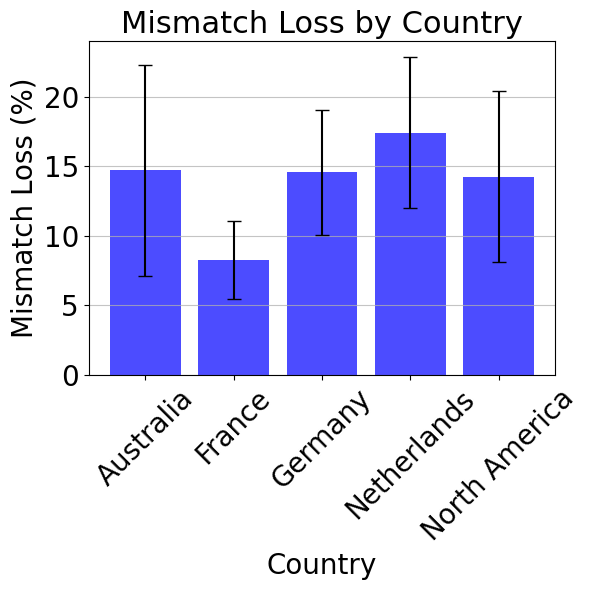

In [13]:

# Group by country and calculate mean and std for mismatch loss
country_stats = combined_df.groupby('Country')['Mismatch Loss (%)'].agg(['mean', 'std'])

plt.figure(figsize=figure_size)
plt.bar(
    country_stats.index,
    country_stats['mean'],
    yerr=country_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Country', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Country', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.show()

### 2.2.4. Group by orientation hist

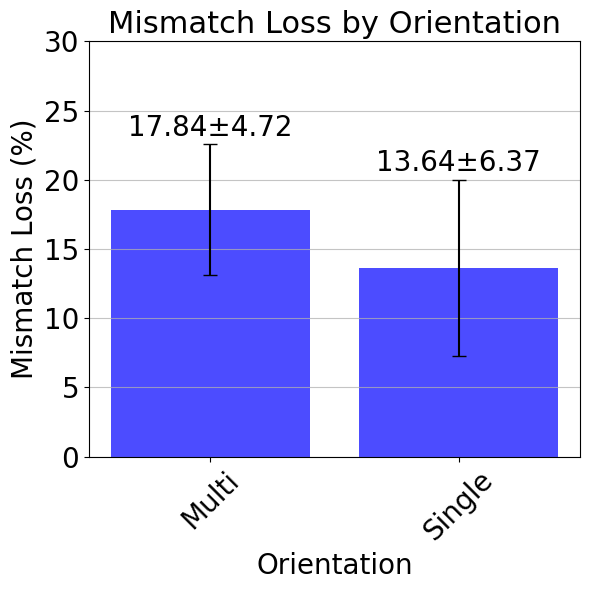

In [14]:
# group by the orientation and calculate mean and std for mismatch loss
orientation_stats = combined_df.groupby('Orientation')['Mismatch Loss (%)'].agg(['mean', 'std'])

plt.figure(figsize=figure_size)
bars = plt.bar(
    orientation_stats.index,
    orientation_stats['mean'],
    yerr=orientation_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Orientation', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Orientation', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.ylim(0, 30)
# Add value and std on top of each bar
for bar, mean, std in zip(bars, orientation_stats['mean'], orientation_stats['std']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.2,
        f"{mean:.2f}±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=axis_num_size
    )
plt.show()

### 2.2.5. Group by shading

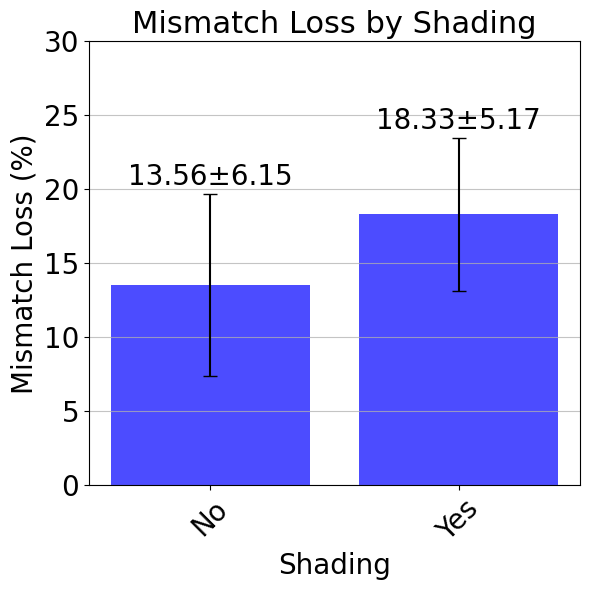

In [15]:
# group by shading and calculate mean and std for mismatch loss
shading_stats = combined_df.groupby('Shade')['Mismatch Loss (%)'].agg(['mean', 'std'])
plt.figure(figsize=figure_size)
bars = plt.bar(
    shading_stats.index,
    shading_stats['mean'],
    yerr=shading_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Shading', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Shading', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.ylim(0, 30)
# Add value and std on top of each bar
for bar, mean, std in zip(bars, shading_stats['mean'], shading_stats['std']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.2,
        f"{mean:.2f}±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=axis_num_size
    )
plt.show()

### 2.2.6. Group by season

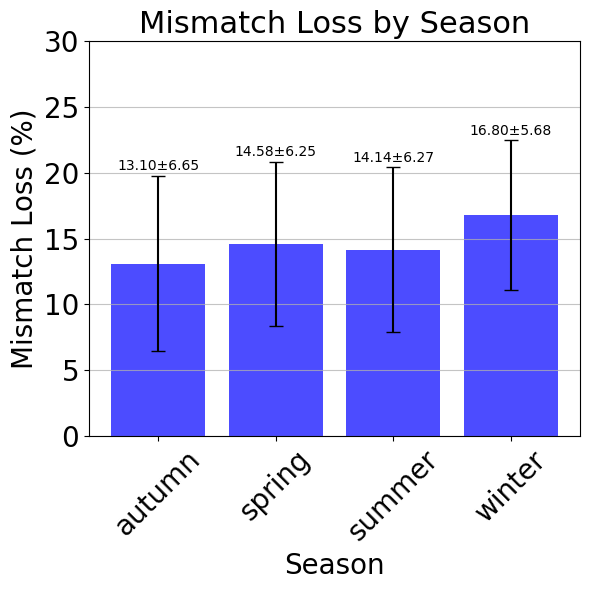

In [16]:
# group by season and calculate mean and std for mismatch loss
season_stats = combined_df.groupby('Season')['Mismatch Loss (%)'].agg(['mean', 'std'])
plt.figure(figsize=figure_size)
bars = plt.bar(
    season_stats.index,
    season_stats['mean'],
    yerr=season_stats['std'],
    color='blue',
    alpha=0.7,
    capsize=5
)
plt.xlabel('Season', fontsize=axis_label_size)
plt.ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
plt.title('Mismatch Loss by Season', fontsize=title_size)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, fontsize=axis_num_size)
plt.yticks(fontsize=axis_num_size)
plt.tight_layout()
plt.ylim(0, 30)
# Add value and std on top of each bar
for bar, mean, std in zip(bars, season_stats['mean'], season_stats['std']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.2,
        f"{mean:.2f}±{std:.2f}",
        ha='center',
        va='bottom',
        fontsize=axis_num_size-10
    )
plt.show()

### 2.2.7. Plot against sytem size

autumn: Slope = -0.0341
spring: Slope = -0.1161
summer: Slope = 0.1086
winter: Slope = 0.3782


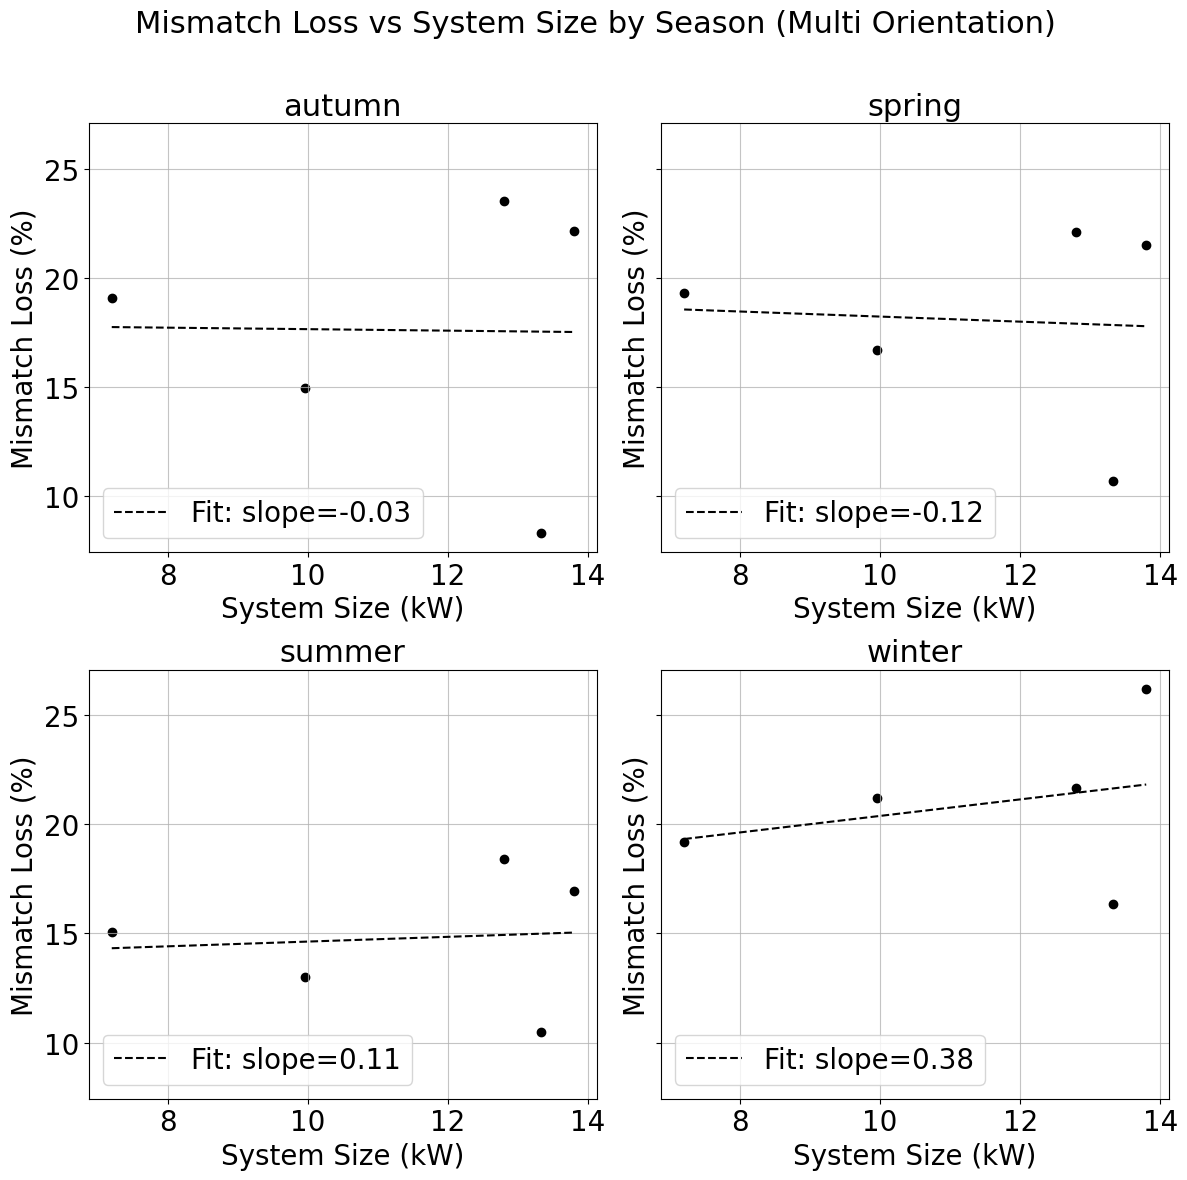

autumn: Slope = -0.0410
summer: Slope = 0.1341
winter: Slope = -0.4183
spring: Slope = 0.2752


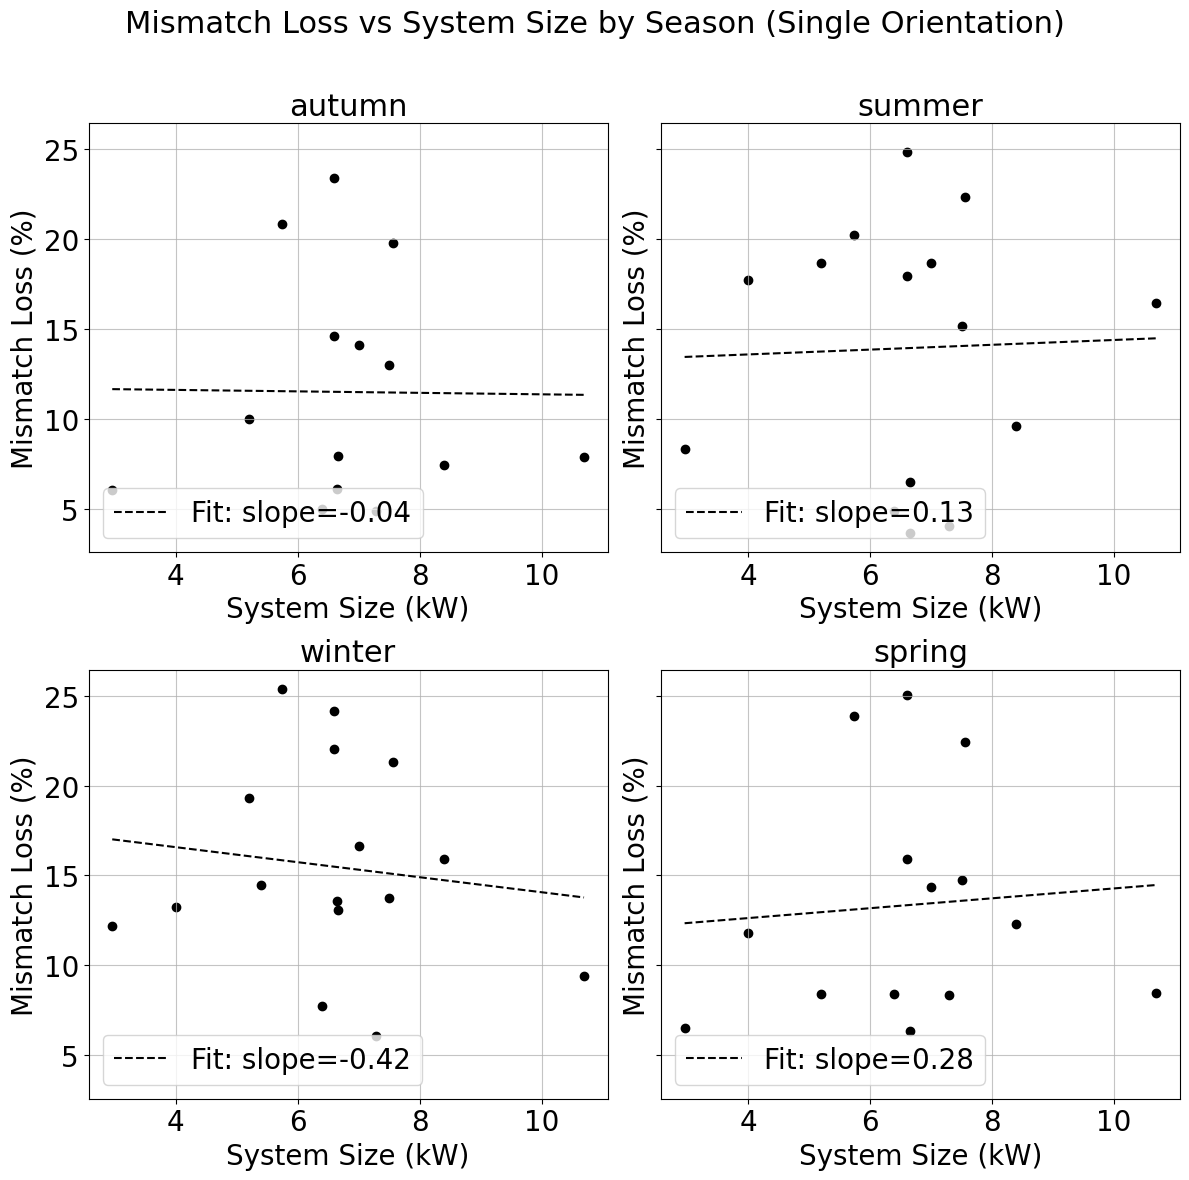

In [17]:
# only plot the site with multiple orientations
multiple_orientations = combined_df[combined_df['Orientation'].str.lower() == 'multi']

# create a new figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=two_by_two_figsize, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# group by season and plot the mismatch loss vs system size
seasons = multiple_orientations['Season'].unique()
for idx, season in enumerate(seasons):
    ax = axes.flatten()[idx]  # Use a different subplot for each season
    subset = multiple_orientations[multiple_orientations['Season'] == season]
    ax.scatter(
        subset['kWp'],
        subset['Mismatch Loss (%)'],
        color='black'
    )
    # Fit line
    if not subset.empty:
        x = subset['kWp'].values
        y = subset['Mismatch Loss (%)'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            slope = coeffs[0]
            xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            yfit = np.polyval(coeffs, xfit)
            ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
            print(f"{season}: Slope = {slope:.4f}")
        else:
            slope = np.nan
    ax.set_xlabel('System Size (kW)', fontsize=axis_label_size)
    ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
    ax.set_title(f'{season}', fontsize=title_size)
    ax.tick_params(axis='y', labelsize=axis_num_size)
    ax.tick_params(axis='x', labelsize=axis_num_size)
    ax.grid(alpha=0.75)
    ax.legend(fontsize=axis_num_size, loc='lower left')  # Only fit line in legend

plt.suptitle('Mismatch Loss vs System Size by Season (Multi Orientation)', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# only plot the site with single orientation
single_orientations = combined_df[combined_df['Orientation'].str.lower() == 'single']

# create a new figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=two_by_two_figsize, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# group by season and plot the mismatch loss vs system size
seasons = single_orientations['Season'].unique()
for idx, season in enumerate(seasons):
    ax = axes.flatten()[idx]  # Use a different subplot for each season
    subset = single_orientations[single_orientations['Season'] == season]
    ax.scatter(
        subset['kWp'],
        subset['Mismatch Loss (%)'],
        color='black'
    )
    # Fit line
    if not subset.empty:
        x = subset['kWp'].values
        y = subset['Mismatch Loss (%)'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, 1)
            slope = coeffs[0]
            xfit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
            yfit = np.polyval(coeffs, xfit)
            ax.plot(xfit, yfit, 'k--', label=f'Fit: slope={slope:.2f}')
            print(f"{season}: Slope = {slope:.4f}")
        else:
            slope = np.nan
    ax.set_xlabel('System Size (kW)', fontsize=axis_label_size)
    ax.set_ylabel('Mismatch Loss (%)', fontsize=axis_label_size)
    ax.set_title(f'{season}', fontsize=title_size)
    ax.tick_params(axis='y', labelsize=axis_num_size)
    ax.tick_params(axis='x', labelsize=axis_num_size)
    ax.grid(alpha=0.75)
    ax.legend(fontsize=axis_num_size, loc='lower left')  # Only fit line in legend

plt.suptitle('Mismatch Loss vs System Size by Season (Single Orientation)', fontsize=title_size)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Internal bypass diode study

## 3.1. Voc outlier detector

* If has Voc higher than normal, labelld 1
* If loss 1/3 of Voc, labelled -1
* If loss 2/3 of Voc, labelled -2
* Else, labelled 0

In [18]:
# define the site id
site_id = '4002138'
# define the season
season = 'autumn'
# define the iqr factor for Voc too high
iqr_factor_1 = 1.5
# define the iqr factor for lossing 1/3 of Voc
iqr_factor_n1 = 10
# define the iqr factor for lossing 2/3 of Voc
iqr_factor_n2 = 20

def outlier_1_identifier(row, iqr_factor=iqr_factor_1):
    '''
    Identify outliers using the IQR method. This corresponding to the case when Voc is too high.
    '''
    q1 = row.quantile(0.25)
    q3 = row.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + iqr_factor * iqr
    return row > upper

# def outlier_n1_identifier(row, iqr_factor=iqr_factor_n1):
#     '''
#     Identify outliers using the IQR method. This corresponding to the case when we loss 1/3 of Voc
#     '''
#     q1 = row.quantile(0.25)
#     q3 = row.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - iqr_factor * iqr
#     return row < lower

# def outlier_n2_identifier(row, iqr_factor=iqr_factor_n2):
#     '''
#     Identify outliers using the IQR method. This corresponding to the case when we loss 2/3 of Voc
#     '''
#     q1 = row.quantile(0.25)
#     q3 = row.quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - iqr_factor * iqr
#     return row < lower

# Find the folder
target_folder = None
for folder in os.listdir(ResultsFolder):
    if site_id in folder and season in folder.lower():
        target_folder = os.path.join(ResultsFolder, folder)
        print(f"Found folder: {target_folder}")
        break

if target_folder is not None:
    print(f"Found folder: {target_folder}")
    # List files in the folder
    files = os.listdir(target_folder)
    # look for a csv file that contains the word module
    for file in files:
        if 'module' in file.lower() and file.endswith('.csv'):
            target_file = os.path.join(target_folder, file)
            print(f"Found file: {target_file}")
            # read the csv file
            df = pd.read_csv(target_file)
            # remove any row with NaN values
            df = df.dropna()
            # …existing code…
            df_pivot = df.pivot(
                index=['Timestamp'],
                columns=['Optimizer'],
                values=['I0', 'Isc', 'Voc', 'FF', 'Pmp', 'Imp', 'Vmp']
            ).dropna()

            # ensure the index is datetime
            df_pivot.index = pd.to_datetime(df_pivot.index)

            # --- flatten the MultiIndex columns to simple strings ---
            df_pivot.columns = ['{}_{}'.format(var, opt) for var, opt in df_pivot.columns]

            # find the flattened Voc columns
            voc_cols = [c for c in df_pivot.columns if c.startswith('Voc_')]

            # calculate the median of the Voc rows
            # voc_median = df_pivot[voc_cols].median(axis=0)

            # compute three outlier masks row‐wise
            mask1   = df_pivot[voc_cols].apply(lambda row: outlier_1_identifier(row), axis=1)
            # mask_n1 = df_pivot[voc_cols].apply(lambda row: outlier_n1_identifier(row), axis=1)
            # mask_n2 = df_pivot[voc_cols].apply(lambda row: outlier_n2_identifier(row), axis=1)
            
            # define mask_n1 & mask_n2 using the median of each row
            mask_n1 = df_pivot[voc_cols].apply(
                lambda row: (row < 5/6 * row.median()) & (row > 1/3 * row.median()),
                axis=1
            )
            mask_n2 = df_pivot[voc_cols].apply(
                lambda row: row < 1/3 * row.median(),
                axis=1
            )
            # combine all masks into a single label a single label: 
            #   1 if mask1, -1 if mask_n1, -2 if mask_n2, else 0
            for col in voc_cols:
                df_pivot[f'{col}_outlier_label'] = np.where(
                    mask1[col],   1,
                    np.where(mask_n1[col], -1,
                            np.where(mask_n2[col], -2, 0))
                )

            # print the outlier labels
            print(df_pivot[[col for col in df_pivot.columns if col.endswith('_outlier_label')]].head(10))


Found folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_autumn_20250516_150724
Found folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_autumn_20250516_150724
Found file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4002138_autumn_20250516_150724\module_param_df.csv
                     Voc_251791336_outlier_label  Voc_251791337_outlier_label  \
Timestamp                                                                       
2024-03-15 07:45:00                            0                            0   
2024-03-15 07:50:00                            0                            0   
2024-03-15 07:55:00                            0                            0   
2024-03-15 08:00:00                            0                            0   
2024-03-15 08:05:00

## 3.2. Voc outlier visualiser

In [19]:
# # 3.2. Voc outlier visualiser (with separate lower/upper bounds)
# voc_cols   = [c for c in df_pivot.columns
#               if c.startswith('Voc_') and not c.endswith('_outlier_label')]
# label_cols = [f'{c}_outlier_label' for c in voc_cols]

# for timestamp, group in df_pivot.groupby(level=0):
#     # only plot timestamps where at least one Voc has a "-1" label
#     if (group[label_cols] == -1).any(axis=1).any():
#         vals = group[voc_cols].values.flatten()

#         # compute quartiles and IQR
#         q1, q3  = np.percentile(vals, [25, 75])
#         iqr     = q3 - q1
#         upper_fence    = q3 + iqr_factor_1  * iqr
#         lower_fence_n1 = q1 - iqr_factor_n1 * iqr
#         lower_fence_n2 = q1 - iqr_factor_n2 * iqr

#         fig, ax = plt.subplots(figsize=figure_size)
#         # draw boxplot without custom 'whis' to avoid percentile errors
#         ax.boxplot(
#             vals,
#             vert=True,
#             patch_artist=True,
#             showfliers=False
#         )

#         # overlay custom fence lines
#         ax.axhline(upper_fence,    color='red',    linestyle='--',
#                    label=f'High bound: {upper_fence:.2f} V')
#         ax.axhline(lower_fence_n1, color='orange', linestyle='-.',
#                    label=f'Low bound (1/3 loss): {lower_fence_n1:.2f} V')
#         ax.axhline(lower_fence_n2, color='purple', linestyle=':',
#                    label=f'Low bound (2/3 loss): {lower_fence_n2:.2f} V')

#         # highlight actual outliers
#         out_high = vals[vals > upper_fence]
#         out_n1   = vals[vals < lower_fence_n1]
#         out_n2   = vals[(vals >= lower_fence_n1) & (vals < lower_fence_n2)]
#         xh = np.random.normal(1, 0.02, size=out_high.size)
#         xn1= np.random.normal(1, 0.02, size=out_n1.size)
#         xn2= np.random.normal(1, 0.02, size=out_n2.size)
#         ax.scatter(xh, out_high, c='red',    label='_nolegend_')
#         ax.scatter(xn1, out_n1,   c='orange', label='_nolegend_')
#         ax.scatter(xn2, out_n2,   c='purple', label='_nolegend_')

#         # labels & legend
#         ax.set_title(f'Voc distribution at {timestamp}', fontsize=title_size)
#         ax.set_ylabel('Voc (V)', fontsize=axis_label_size)
#         ax.tick_params(axis='both', labelsize=axis_num_size)
#         ax.grid(axis='y', ls='--', alpha=0.7)
#         ax.legend(
#             loc='upper left',
#             bbox_to_anchor=(1.02, 1),
#             borderaxespad=0,
#             fontsize=axis_num_size
#         )

#         # adjust layout and display
#         fig.tight_layout(rect=[0, 0, 0.8, 1])
#         plt.show()

## 3.3. Isc outlier detector

* If Isc is upper outlier, it is labelled as 1
* If Isc is lower outlier, it is labelled as -1
* Otherwise it is labelled as 0

In [20]:
# 3.3. Isc outlier detector (only high vs low)

# define I-V specific IQR factor for Isc
iqr_factor_isc = 3

def outlier_isc_high(row, iqr_factor=iqr_factor_isc):
    """Isc too high"""
    q1, q3 = row.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + iqr_factor * iqr
    return row > upper

def outlier_isc_low(row, iqr_factor=iqr_factor_isc):
    """Isc too low"""
    q1, q3 = row.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - iqr_factor * iqr
    return row < lower

# find all flattened Isc columns
isc_cols = [c for c in df_pivot.columns if c.startswith('Isc_')]

# compute high/low masks
mask_high_isc = df_pivot[isc_cols].apply(outlier_isc_high, axis=1)
mask_low_isc  = df_pivot[isc_cols].apply(outlier_isc_low,  axis=1)

# assign labels: 1 if too high, -1 if too low, else 0
for col in isc_cols:
    df_pivot[f'{col}_outlier_label'] = np.where(
        mask_high_isc[col],  1,
        np.where(mask_low_isc[col], -1, 0)
    )

# preview the new Isc outlier labels
print(df_pivot[[c for c in df_pivot.columns
                if c.startswith('Isc_') and c.endswith('_outlier_label')]].head(10))

                     Isc_251791336_outlier_label  Isc_251791337_outlier_label  \
Timestamp                                                                       
2024-03-15 07:45:00                            0                            0   
2024-03-15 07:50:00                            0                            0   
2024-03-15 07:55:00                            0                            0   
2024-03-15 08:00:00                            0                            0   
2024-03-15 08:05:00                            0                            0   
2024-03-15 08:10:00                            0                            0   
2024-03-15 08:15:00                            0                            0   
2024-03-15 08:20:00                            0                            0   
2024-03-15 08:25:00                            0                            0   
2024-03-15 08:30:00                            0                            0   

                     Isc_25

## 3.4. Isc outlier visualiser

In [21]:
# # 3.4. Isc outlier visualiser (with separate high/low bounds)

# # flattened Isc columns & their label columns
# isc_cols   = [c for c in df_pivot.columns if c.startswith('Isc_') and not c.endswith('_outlier_label')]
# label_cols = [f'{c}_outlier_label' for c in isc_cols]

# for timestamp, group in df_pivot.groupby(level=0):
#     # skip timestamps without any Isc outlier
#     if not (group[label_cols] != 0).any(axis=1).any():
#         continue

#     # collect all Isc values at this timestamp
#     vals = group[isc_cols].values.flatten()
#     # compute fences
#     q1, q3        = np.percentile(vals, [25, 75])
#     iqr           = q3 - q1
#     upper_fence   = q3 + iqr_factor_isc * iqr
#     lower_fence   = q1 - iqr_factor_isc * iqr

#     fig, ax = plt.subplots(figsize=figure_size)
#     # boxplot without default fliers, using custom whiskers
#     ax.boxplot(
#         vals,
#         vert=True,
#         patch_artist=True,
#         showfliers=False
#         # removed whis=(lower_fence, upper_fence)
#     )

#     # plot fence lines
#     ax.axhline(upper_fence, color='red',    linestyle='--',
#                label=f'High bound: {upper_fence:.2f} A')
#     ax.axhline(lower_fence, color='orange', linestyle='-.',
#                label=f'Low bound:  {lower_fence:.2f} A')

#     # highlight actual outliers
#     out_high = vals[vals > upper_fence]
#     out_low  = vals[vals < lower_fence]
#     xh = np.random.normal(1, 0.02, size=out_high.size)
#     xl = np.random.normal(1, 0.02, size=out_low.size)
#     ax.scatter(xh, out_high, c='red',    label='_nolegend_')
#     ax.scatter(xl, out_low,  c='orange', label='_nolegend_')

#     # styling
#     ax.set_title(f'Isc distribution at {timestamp}', fontsize=title_size)
#     ax.set_ylabel('Isc (A)', fontsize=axis_label_size)
#     ax.tick_params(axis='both', labelsize=axis_num_size)
#     ax.grid(axis='y', ls='--', alpha=0.7)
#     ax.legend(
#         loc='upper left',
#         bbox_to_anchor=(1.02, 1),
#         borderaxespad=0,
#         fontsize=axis_num_size
#     )
#     fig.tight_layout(rect=[0, 0, 0.8, 1])
#     plt.show()

## 3.5. Diode activation condition definition

- For type 1:
    - Description: Isc is not changed but we lose 1/3 of Voc, this is one case when one diode is activated
    - Voc condition: Voc is lower than the 1/3 lower bound
    - Isc condition: not an outlier
- For type 2:
    - Description: Isc is not changedd but we lose 2/3 of Voc, this is one case when two diodes are activated
    - Voc condition: Voc is lower than the 2/3 lower bound
    - Isc condition: not an outlier
- For type -1
    - Description: Isc is an loew outlier, Voc is an higher outlier, this case can happen when 1, 2, or 3 diodes are activated
    - Voc condition: Voc is higher outlier
    - Isc condition: lower outlier
- Others: 0

In [22]:
# …existing code before diode‐activation…

# build lists of your outlier‐label cols
voc_label_cols = [c for c in df_pivot.columns
                  if c.startswith('Voc_') and c.endswith('_outlier_label')]
isc_label_cols = [c for c in df_pivot.columns
                  if c.startswith('Isc_') and c.endswith('_outlier_label')]

# for each Voc_xxx_outlier_label, pick the matching Isc_xxx_outlier_label
for voc_col in voc_label_cols:
    opt     = voc_col.replace('Voc_', '').replace('_outlier_label', '')
    isc_lab = f'Isc_{opt}_outlier_label'
    act_col = f'{opt}_diode_activation'
    if isc_lab not in df_pivot.columns:
        continue

    # define conditions
    conds   = [
        (df_pivot[voc_col] == -1) & (df_pivot[isc_lab] == 0),
        (df_pivot[voc_col] == -2) & (df_pivot[isc_lab] == 0),
        (df_pivot[voc_col] ==  1) & (df_pivot[isc_lab] == -1)
    ]
    choices = [1, 2, -1]

    # assign activation label
    df_pivot[act_col] = np.select(conds, choices, default=0)

    # if actual Isc < 1 A, force activation to 0
    # df_pivot.loc[df_pivot[f'Isc_{opt}'] < 1, act_col] = 0

# ensure the index has a name
df_pivot.index.name = 'Timestamp'

# export with the Timestamp as index
df_pivot.to_csv(
    os.path.join(ResultsFolder, 'outlier_labels.csv'),
    index=True,
    index_label='Timestamp'
)

## 3.6. Diode activation visualise

In [23]:
# collect all diode‐activation columns
act_cols = [c for c in df_pivot.columns if c.endswith('_diode_activation')]

# select rows where any activation ≠ 0
diode_activation = df_pivot[(df_pivot[act_cols] != 0).any(axis=1)]

# for each timestamp and each activated optimiser, print the diode‐activation value
# along with its corresponding Voc and Isc outlier labels
for ts, row in diode_activation.iterrows():
    for act_col in act_cols:
        act_val = row[act_col]
        if act_val != 0:
            opt = act_col.replace('_diode_activation','')
            voc_label = f'Voc_{opt}_outlier_label'
            isc_label = f'Isc_{opt}_outlier_label'
            print(f"{ts} → {act_col}={act_val}, "
                  f"{voc_label}={row.get(voc_label,'NA')}, "
                  f"{isc_label}={row.get(isc_label,'NA')}")

2024-03-15 17:40:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 17:45:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 17:50:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 17:55:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 18:00:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 18:00:00 → 251791351_diode_activation=-1.0, Voc_251791351_outlier_label=1.0, Isc_251791351_outlier_label=-1.0
2024-03-15 18:05:00 → 251791341_diode_activation=-1.0, Voc_251791341_outlier_label=1.0, Isc_251791341_outlier_label=-1.0
2024-03-15 18:05:00 → 251791351_diode_activation=-1.0, Voc_251791351_outlier_label=1.0, Isc_251791351_outlier_label=-1.0
2024-03-15 18:10:00 → 251791341_